In [1]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import pandas as pd
import numpy as np
import pydicom
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import warnings
import random

warnings.filterwarnings("ignore", category=UserWarning, module="pydicom")

In [4]:
# Rutas a los directorios
train_dir = '/content/drive/MyDrive/DP4/train'
test_dir = '/content/drive/MyDrive/DP4/test'
train_csv = '/content/drive/MyDrive/DP4/train.csv'

# Cargar los datos de entrenamiento
train_df = pd.read_csv(train_csv)

# Visualizar algunas filas del DataFrame
train_df.head(10)

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10062189329714053601...,14
1,1.2.826.0.1.3680043.8.498.53411283183733547704...,3
2,1.2.826.0.1.3680043.8.498.12955484645689261949...,3
3,1.2.826.0.1.3680043.8.498.10408703585974384892...,3
4,1.2.826.0.1.3680043.8.498.30255106562321206269...,9
5,1.2.826.0.1.3680043.8.498.80404681981834387091...,0
6,1.2.826.0.1.3680043.8.498.16743022096024694044...,2
7,1.2.826.0.1.3680043.8.498.33303514480609398517...,2
8,1.2.826.0.1.3680043.8.498.15144815417970827102...,13
9,1.2.826.0.1.3680043.8.498.19878644487806502082...,3


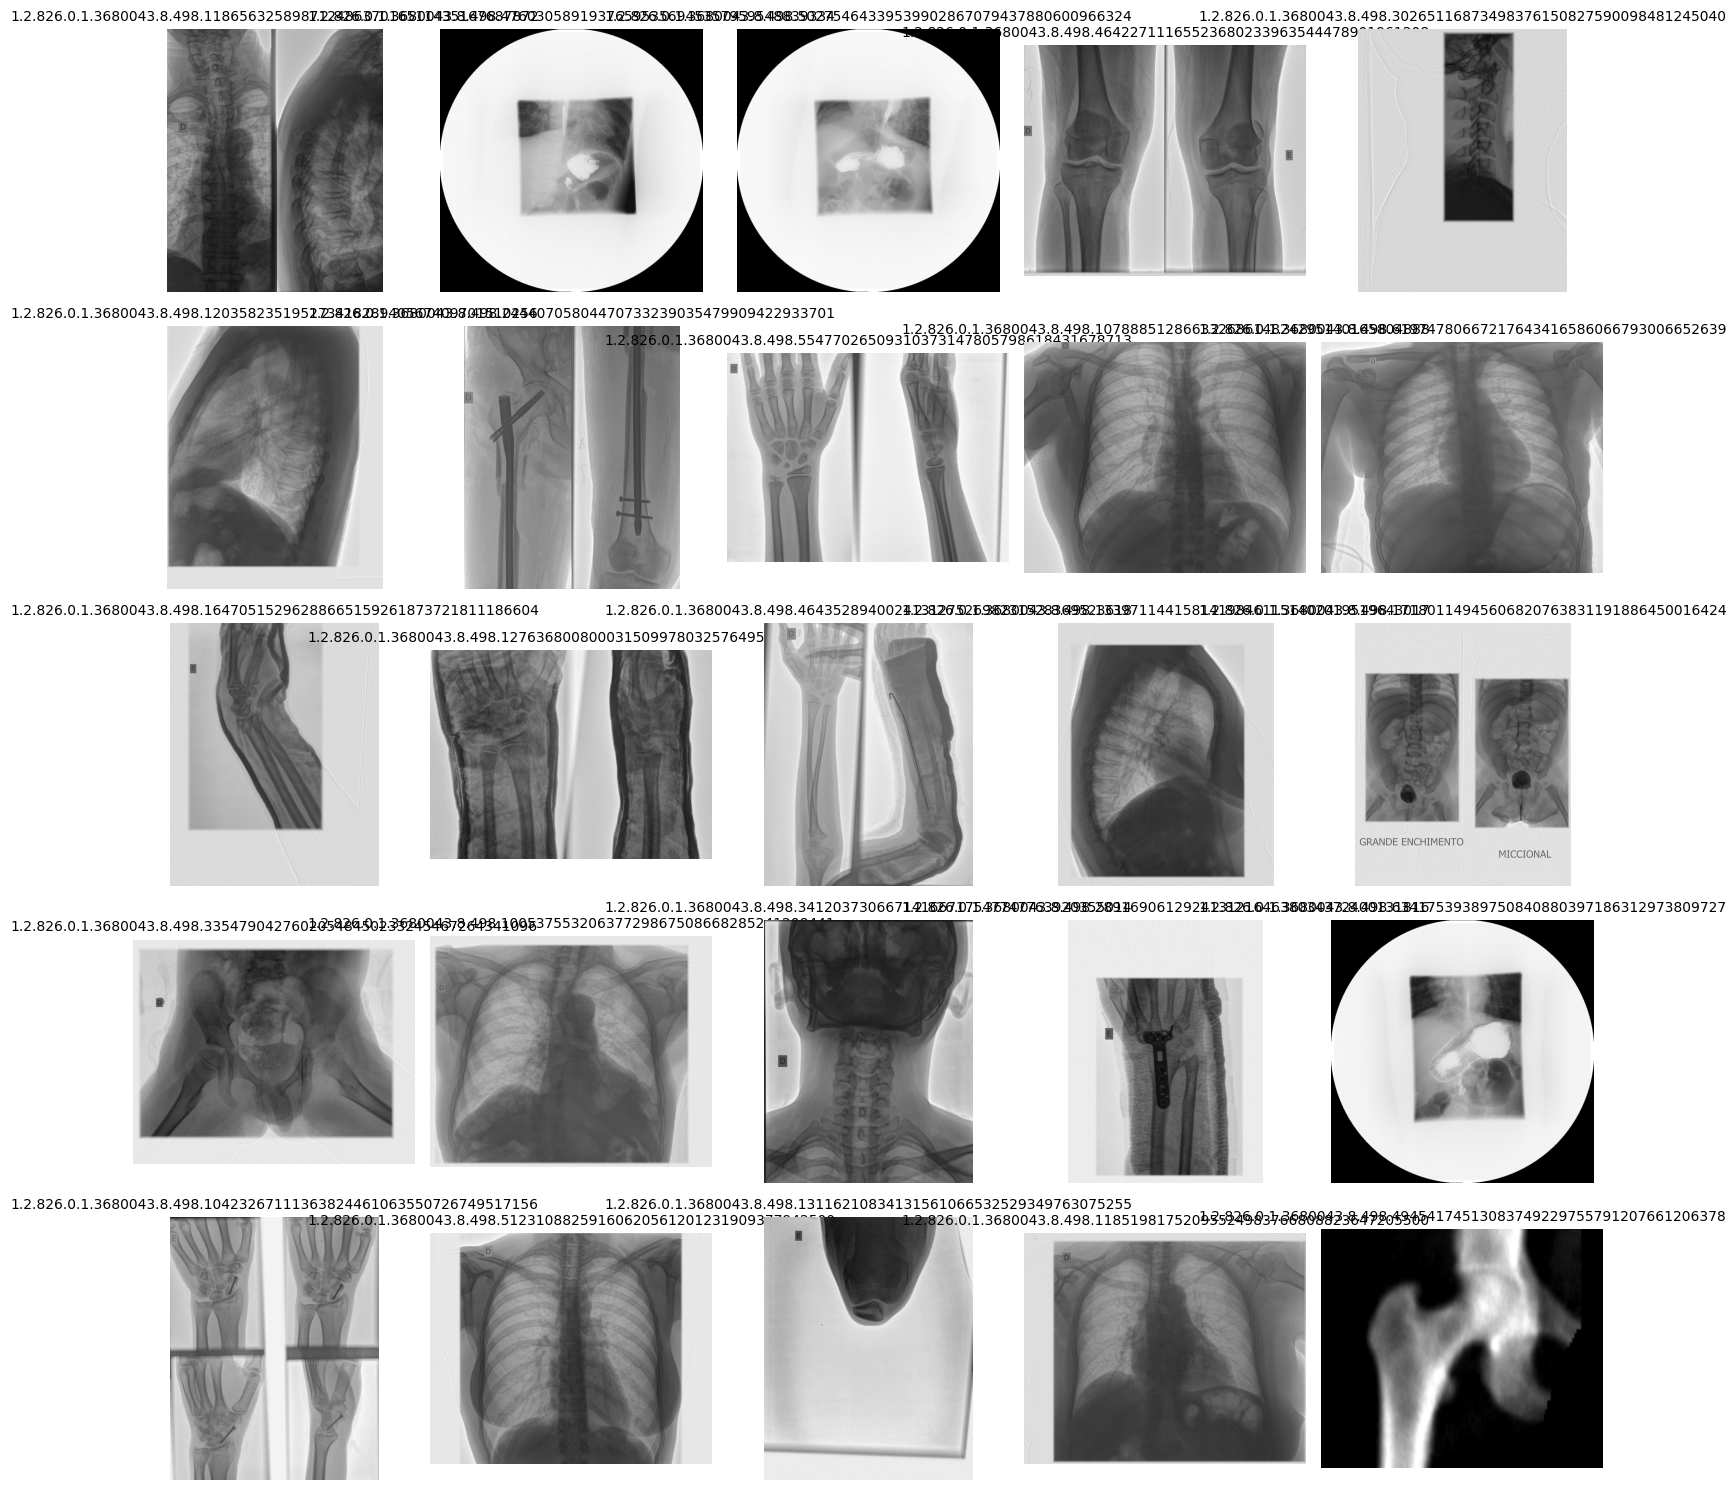

In [ ]:
# Función para mostrar una imagen DICOM y su referencia
def show_dicom_image_multi(file_path, ax, title):
    dicom = pydicom.dcmread(file_path)
    ax.imshow(dicom.pixel_array, cmap='gray')
    ax.axis('off')  # Desactivar ejes
    ax.set_title(title, fontsize=10)  # Añadir título

# Seleccionar 25 imágenes al azar
random_indices = random.sample(range(len(train_df)), 25)
random_image_paths = [os.path.join(train_dir, train_df.iloc[i]['SOPInstanceUID'] + '.dcm') for i in random_indices]
random_titles = [train_df.iloc[i]['SOPInstanceUID'] for i in random_indices]

# Crear una figura y ejes para una matriz de 5x5
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

# Mostrar cada imagen en su correspondiente subgráfico con su referencia
for ax, image_path, title in zip(axes.flat, random_image_paths, random_titles):
    show_dicom_image_multi(image_path, ax, title)

# Ajustar el espacio entre subgráficos
plt.tight_layout()
plt.show()


Paso 1: Leer y preprocesar las imágenes DICOM
Vamos a convertir las imágenes DICOM en arrays de píxeles y normalizarlas. También redimensionaremos las imágenes para que tengan un tamaño uniforme.

In [5]:
# Definir el tamaño al que redimensionaremos las imágenes
IMG_SIZE = 224

# Función para leer y procesar una imagen DICOM
def process_dicom_image(file_path):
    dicom = pydicom.dcmread(file_path)
    image = dicom.pixel_array
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = np.stack((image,)*3, axis=-1)  # Convertir a 3 canales
    image = image / 255.0  # Normalizar los píxeles
    return image

# Aplicar la función a todas las imágenes del conjunto de entrenamiento
X = np.array([process_dicom_image(os.path.join(train_dir, uid + '.dcm')) for uid in tqdm(train_df['SOPInstanceUID'])])
y = np.array(train_df['Target'])

print(X.shape, y.shape)


100%|██████████| 1278/1278 [2:17:24<00:00,  6.45s/it]


(1278, 224, 224, 3) (1278,)


Paso 2: Codificar las etiquetas
Usamos LabelEncoder para convertir las etiquetas de texto en valores numéricos.

In [4]:
# Codificar las etiquetas
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(y_encoded[:10])


NameError: name 'y' is not defined

In [7]:
import numpy as np
import zipfile

# Guardar las imágenes preprocesadas en un archivo comprimido
with zipfile.ZipFile('/content/drive/MyDrive/DP4/preprocessed_images_train.zip', 'w') as zipf:
    for i, image in enumerate(X):
        filename = f'image_{i}.npy'
        np.save(filename, image)
        zipf.write(filename)
        os.remove(filename)  # Eliminar el archivo npy después de guardarlo en el ZIP

print('Imágenes preprocesadas guardadas en preprocessed_images_train.zip')


Imágenes preprocesadas guardadas en preprocessed_images_train.zip


Paso 3: Dividir los datos en conjuntos de entrenamiento y validación
Usamos train_test_split para dividir los datos.

In [1]:
# Dividir los datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


NameError: name 'train_test_split' is not defined

Paso 4: Definir y compilar un modelo básico
Usaremos ResNet50 como modelo base y añadiremos algunas capas densas para la clasificación.

In [ ]:
# Definir el modelo usando ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas de clasificación
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(np.unique(y_encoded)), activation='softmax')(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Paso 5: Entrenar el modelo
Definimos un EarlyStopping para evitar el sobreajuste y entrenamos el modelo.

Epoch 1/20
32/32 [==============================] - 19s 280ms/step - loss: 1.4068 - accuracy: 0.6879 - val_loss: 0.5326 - val_accuracy: 0.8320
Epoch 2/20
32/32 [==============================] - 4s 124ms/step - loss: 0.3416 - accuracy: 0.8992 - val_loss: 0.3953 - val_accuracy: 0.8984
Epoch 3/20
32/32 [==============================] - 4s 125ms/step - loss: 0.1806 - accuracy: 0.9560 - val_loss: 0.3770 - val_accuracy: 0.9062
Epoch 4/20
32/32 [==============================] - 4s 139ms/step - loss: 0.0974 - accuracy: 0.9775 - val_loss: 0.3780 - val_accuracy: 0.9219
Epoch 5/20
32/32 [==============================] - 4s 125ms/step - loss: 0.0641 - accuracy: 0.9883 - val_loss: 0.3761 - val_accuracy: 0.9219
Epoch 6/20
32/32 [==============================] - 4s 126ms/step - loss: 0.0557 - accuracy: 0.9883 - val_loss: 0.3448 - val_accuracy: 0.9219
Epoch 7/20
32/32 [==============================] - 5s 143ms/step - loss: 0.0366 - accuracy: 0.9932 - val_loss: 0.3197 - val_accuracy: 0.9375
Epoch

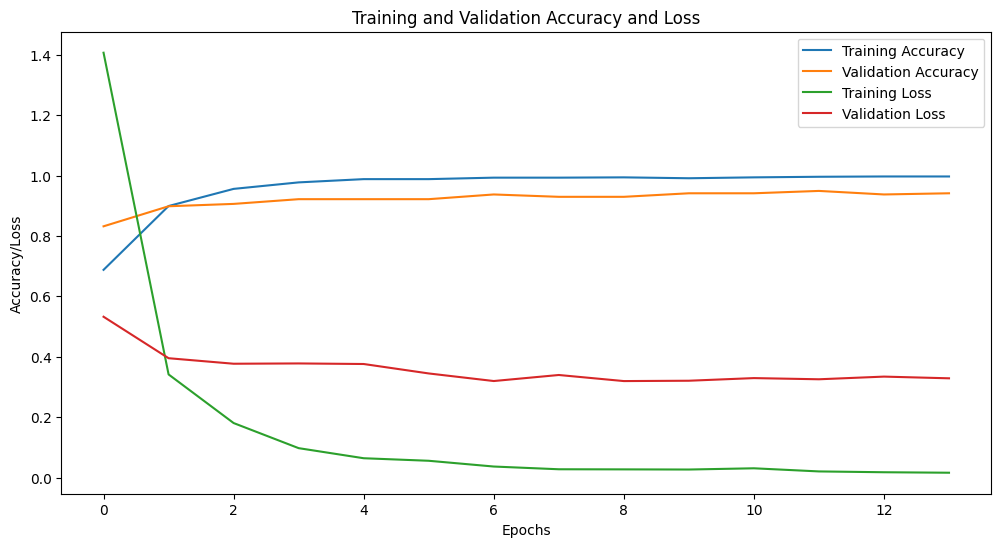

In [10]:
# Definir EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

# Graficar los resultados del entrenamiento
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.show()


Realizar el preprocesado de las imagenes de test.

In [ ]:
# Definir el tamaño al que redimensionaremos las imágenes
IMG_SIZE = 224

# Función para leer y procesar una imagen DICOM de test
def process_dicom_image_test(file_path):
    dicom = pydicom.dcmread(file_path)
    image = dicom.pixel_array
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = np.stack((image,)*3, axis=-1)  # Convertir a 3 canales
    image = image / 255.0  # Normalizar los píxeles
    return image

# Listar todos los archivos en el directorio de test
test_files = [f for f in os.listdir(test_dir) if f.endswith('.dcm')]

# Aplicar la función de preprocesamiento a todas las imágenes del conjunto de test
X_test = np.array([process_dicom_image_test(os.path.join(test_dir, f)) for f in tqdm(test_files)])

print(X_test.shape)

In [ ]:
import numpy as np
import zipfile

# Guardar las imágenes preprocesadas en un archivo comprimido
with zipfile.ZipFile('/content/drive/MyDrive/DP4/preprocessed_images_test.zip', 'w') as zipf:
    for i, image in enumerate(X):
        filename = f'image_{i}.npy'
        np.save(filename, image)
        zipf.write(filename)
        os.remove(filename)  # Eliminar el archivo npy después de guardarlo en el ZIP

print('Imágenes preprocesadas guardadas en preprocessed_images_test.zip')

In [ ]:
# Cargar el modelo si no está en memoria (esto es opcional si el modelo ya está entrenado y en memoria)
model.save('/content/drive/MyDrive/DP4/trained_model.h5')
model = tf.keras.models.load_model('/content/drive/MyDrive/DP4/trained_model.h5')

# Realizar predicciones sobre el conjunto de test
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Crear un DataFrame con los resultados
submission_df = pd.DataFrame({
    'SOPInstanceUID': [os.path.splitext(f)[0] for f in test_files],
    'PredictedLabel': le.inverse_transform(y_pred_labels)
})

# Guardar el DataFrame en un archivo CSV
submission_csv_path = '/content/drive/MyDrive/DP4/prediccion2.csv'
submission_df.to_csv(submission_csv_path, index=False)

print(f'Predicciones guardadas en {submission_csv_path}')


In [ ]:
submission_df.head()

In [ ]:
from google.colab import files
files.download('prediccion2.csv')